In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 4.2 Carregamento do dataset
train_df = pd.read_csv("Train_data.csv")
test_df  = pd.read_csv("Test_data.csv")

print("Shape treino:", train_df.shape )
print("Colunas:", train_df.columns)
print("Valor único da coluna alvo (ex):\n", train_df["class"].value_counts(dropna=False))
print("\n===================\n")

print("Shape Teste:", test_df.shape)
print("Colunas:", test_df.columns)

Shape treino: (25192, 42)
Colunas: Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')
Valor único da coluna alvo (ex):
 class
normal     13449
anomaly    11743
Name: count, dtype: int64


Shape Teste:

In [3]:
X = train_df.drop(columns=["class"])
y = train_df["class"]

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.20,
    random_state=19,
    stratify=y
)

In [ ]:
categorical_cols = X_train.select_dtypes(include=["object"]).columns

X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_valid = pd.get_dummies(X_valid, columns=categorical_cols)

X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [40]:
mlp = MLPClassifier(
    hidden_layer_sizes=(120, 80),
    solver='adam',
    max_iter=200,
    random_state=19
)

mlp.fit(X_train_scaled, y_train)

,hidden_layer_sizes,"(120, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,200
,shuffle,True
,random_state,19


In [38]:
y_pred = mlp.predict(X_valid_scaled)

In [39]:
accuracy = accuracy_score(y_valid, y_pred)
print(f"\nAcurácia: {accuracy:.4f}\n")

print("Relatório de Classificação:")
print(classification_report(y_valid, y_pred))


Acurácia: 0.9950

Relatório de Classificação:
              precision    recall  f1-score   support

     anomaly       0.99      1.00      0.99      2349
      normal       1.00      0.99      1.00      2690

    accuracy                           1.00      5039
   macro avg       0.99      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



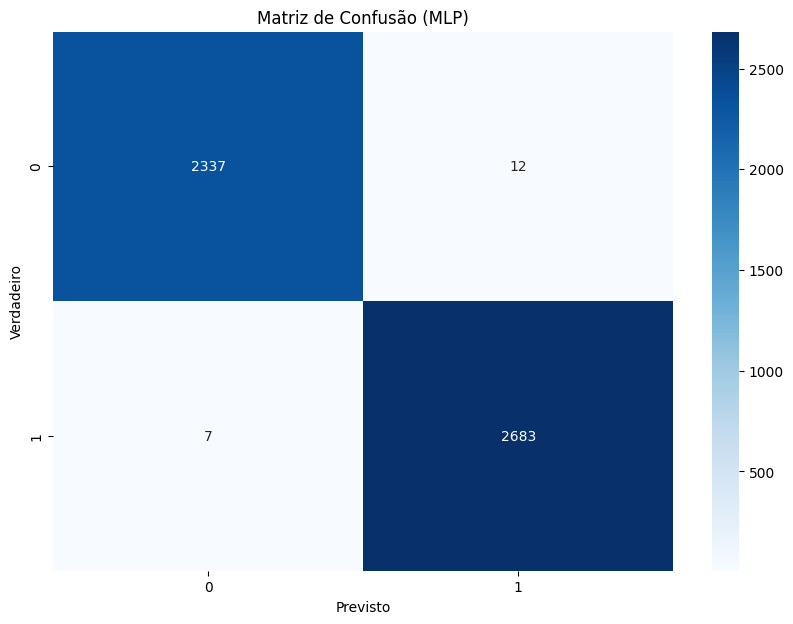

In [18]:
cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão (MLP)")
plt.show()

Top 20 Features Mais Importantes:
dst_bytes                   0.138281
count                       0.000318
num_compromised             0.000060
urgent                      0.000000
wrong_fragment              0.000000
land                        0.000000
is_host_login               0.000000
is_guest_login              0.000000
num_failed_logins           0.000000
hot                         0.000000
num_file_creations          0.000000
su_attempted                0.000000
num_shells                  0.000000
root_shell                  0.000000
serror_rate                 0.000000
num_access_files            0.000000
num_outbound_cmds           0.000000
dst_host_srv_rerror_rate    0.000000
diff_srv_rate               0.000000
srv_diff_host_rate          0.000000
dtype: float64


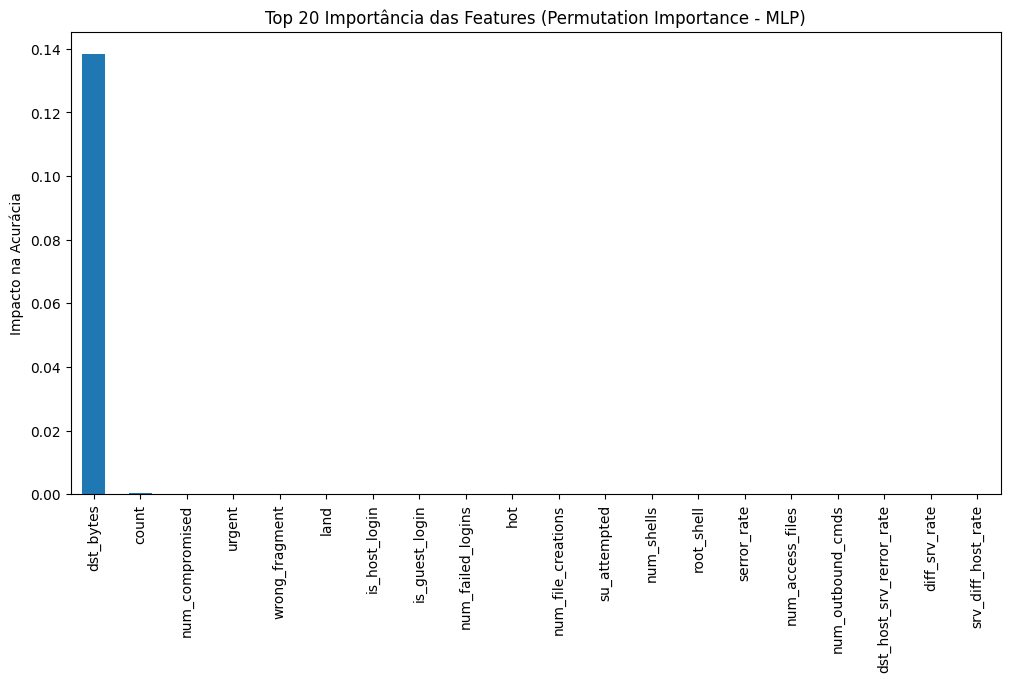

In [19]:
from sklearn.inspection import permutation_importance

# Calcular importância via permutação (convertido para array para evitar warning)
resultado = permutation_importance(
    mlp,
    X_valid.values,   # evita o warning
    y_valid,
    n_repeats=10,
    random_state=123,
    n_jobs=-1
)

# Criar Series com nomes originais das features
importances = pd.Series(resultado.importances_mean, index=X_valid.columns)

# Ordenar e truncar para top 20 (ou outro valor)
importances = importances.sort_values(ascending=False)
top_k = 20
importances_trunc = importances.head(top_k)

print(f"Top {top_k} Features Mais Importantes:")
print(importances_trunc)

# Plot
plt.figure(figsize=(12,6))
importances_trunc.plot(kind='bar')
plt.title(f"Top {top_k} Importância das Features (Permutation Importance - MLP)")
plt.ylabel("Impacto na Acurácia")
plt.show()


## Prevendo e utilizando no conjunto de teste

anomaly    43.231015
normal     56.768985
Name: proportion, dtype: float64


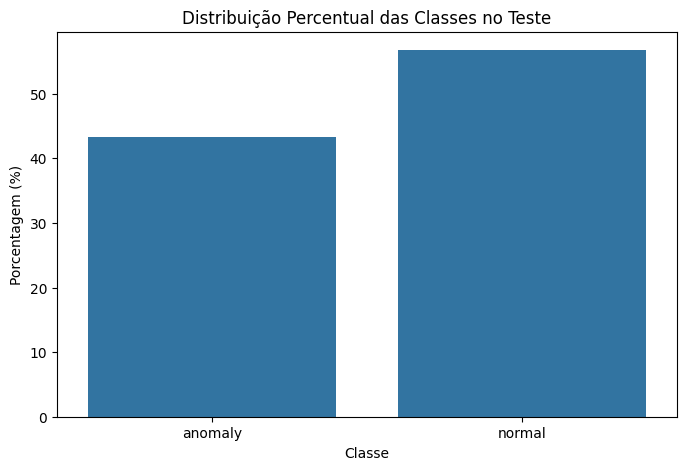

In [21]:
X_test = test_df.copy()

categorical_cols = X_test.select_dtypes(include=["object"]).columns
X_test = pd.get_dummies(X_test, columns=categorical_cols)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

X_test_scaled = scaler.transform(X_test)

test_pred = mlp.predict(X_test_scaled)

percentuais = (pd.Series(test_pred).value_counts(normalize=True) * 100).sort_index()
print(percentuais)

plt.figure(figsize=(8,5))
sns.barplot(x=percentuais.index, y=percentuais.values)
plt.title("Distribuição Percentual das Classes no Teste")
plt.xlabel("Classe")
plt.ylabel("Porcentagem (%)")
plt.show()


## Vendo correlação entre Src_bytes e dst_bytes


Correlação entre src_bytes e dst_bytes:

           src_bytes  dst_bytes
src_bytes   1.000000   0.003611
dst_bytes   0.003611   1.000000


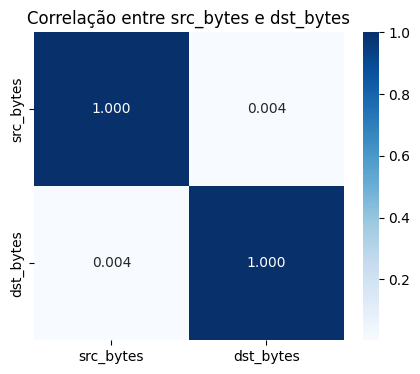

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleciona apenas as duas colunas
corr = train_df[['src_bytes', 'dst_bytes']].corr()

print("\nCorrelação entre src_bytes e dst_bytes:\n")
print(corr)

# Heatmap
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".3f")
plt.title("Correlação entre src_bytes e dst_bytes")
plt.show()


## Análise comparativa entre MLP e Random Forest
A análise de importância das variáveis mostrou resultados distintos entre os modelos: no Random Forest, src_bytes apareceu como a variável mais relevante, enquanto no MLP, utilizando Permutation Importance, a variável de maior impacto foi dst_bytes. Essa diferença é esperada, pois cada algoritmo adota critérios próprios para estimar relevância. O Random Forest baseia-se na redução de impureza nas árvores, enquanto a Permutation Importance avalia a queda de desempenho ao embaralhar cada variável, o que pode destacar aspectos diferentes do mesmo conjunto de dados.

A correlação entre src_bytes e dst_bytes revelou um valor próximo de zero, indicando ausência de relação linear direta entre as duas variáveis. Isso sugere que cada uma contribui de forma independente para o processo de classificação, o que ajuda a explicar por que modelos com arquiteturas distintas podem priorizar features específicas.